# Fundamentals of Data Analysis, Winter 21/22
- Author: Brendan Tunney
- ID - G00270683

![](https://upload.wikimedia.org/wikipedia/commons/5/51/Central_Applications_Office.png)

## Background

The Central Applications Office (CAO) oversees undergraduate applications to third level institutions in Ireland.

The CAO primarily operates on a points system which is based on applicants Leaving Certificate exams.

## Importing the CAO data


In [1]:
#Importing libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re # regular expressions {1}
import requests as rq #{1} # To retrieve HTTP Data
import urllib.request as urlrq # Importing pythons URL module
import csv # importing csv module to read, write csv
from unicodedata import normalize # Imported to use normalised string values.
# Dates and times.
import datetime as dt # Importing date/time module


### 2021 Points

In [2]:
resp = rq.get('http://www2.cao.ie/points/l8.php') # Getting CAO points data for 2021

resp # checking response. 200 = succesful

<Response [200]>

In [3]:
now = dt.datetime.now() # Get the current date and time.

nowstr = now.strftime('%Y%m%d_%H%M%S') # # Format date and time as a string.

pathhtml = 'resp_' + nowstr + '.html' # Creating file path

In [4]:
# If we decode per server as ISO-8859-1, it will be noted that one line uses \x96 - not defined in ISO-8859-1. CP1252 is used instead.

original_encoding = resp.encoding

resp.encoding = 'cp1252'


In [5]:
re_course = re.compile(r'([A-Z]{2}[0-9]{3})(.*)') # Compile the reg. expressions.

In [6]:
with open(pathhtml, 'w') as f:
    f.write(resp.text)

In [7]:
path2021 = 'df2021'  + '.csv'

In [8]:
no_lines = 0 # Counting # of lines processed

with open(path2021, 'w') as f:                                            # Open csv file to write
   
    f.write(','.join(['code', 'title', 'pointsR1', 'pointsR2']) + '\n')   # Write file header
    for line in resp.iter_lines():                                        # Loop thorugh lines of response data
        dline = line.decode('cp1252')                                     # Decode line
        if re_course.fullmatch(dline):                                    # Match only lines with a course
            no_lines = no_lines + 1                                       # If matched,add '1' to the counter
            course_code = dline[:5]                                       # Course code (5 characters)
            course_title = dline[7:57].strip()                            # Course title and stripping out blanks
            course_points = re.split(' +', dline[60:])                    # First round points accounting for spaces
            if len(course_points) != 2:                                   # Second round points - if applicable.
                course_points = course_points[:2]
            linesplit = [course_code, course_title, course_points[0], course_points[1]] # Creating header array.
            f.write(','.join(linesplit) + '\n')                           # Rejoining split values with comma seperation and adding new line for each course

print(f"Total number of lines is {no_lines}.")                            # Number of processed lines

Total number of lines is 949.


In [9]:
df2021 = pd.read_csv(path2021, encoding='cp1252')

### 2020 Points

In [10]:
url = 'http://www2.cao.ie/points/CAOPointsCharts2020.xlsx' # URL for 2020 points
    
df2020 = pd.read_excel(url, skiprows = 10)                 # read in excel file, skipping first 10 rows that do not contain course data    

# Renaming columns to match 2021 file

df2020.rename(columns={"COURSE CODE2": "code", "R1 POINTS": "pointsR1", "R2 POINTS": "pointsR2", "COURSE TITLE": "title"}, inplace=True)

new_col_order = ['code', 'title', 'pointsR1', 'pointsR2', 'EOS','LEVEL']   # New column order list
df2020 = df2020.reindex(columns = new_col_order)                     # Re-ordering columns

df2020 = df2020.loc[df2020.loc[:, 'LEVEL'] == 8]                     # Added to filter for just level 8 - matching current data for 2021 & 2019

df2020.set_index('code', inplace=True)                               # set idex column to ''code''



In [11]:
data2020 = 'df2020' + '.csv' # Filepath for df

In [12]:
df2020.to_csv(data2020) # saving df

### 2019 Points

In [13]:
import tabula # importing tabula module for pdf read

In [14]:
url = 'http://www2.cao.ie/points/lvl8_19.pdf'

#df2019 = tabula.read_pdf(url, pages = "all") # reading in table, important to specify pages = "all" or you will only read 1

tabula.convert_into(url, "df2019.csv", output_format="csv", pages='all') # Using tabula module to convert to csv

In [15]:
df2019 = pd.read_csv('df2019.csv', sep=',')
df2019.dropna(                         # Using drop function to remove blank (NaN lines)
    axis=0,                            # "0" = Row. "1" = Column
    how='any',                         # "Any" will remove a row with just a single blank cell
    thresh=None,                       # Can be used to set a 'threshold' of how many empty cells are tolerated
    subset=None,                       # Set the array to be considered, none defaults to all
    inplace=True                       # Must be set to "true" to allow changes to be made
 )

df2019.rename(columns={"Course Code": "code","INSTITUTION and COURSE":"title"}, inplace =True)

df2019.set_index('code', inplace=True) # set idex column to ''code''

data2019 = 'df2019' + '.csv'
df2019.to_csv(data2019) # creating new df

### CAO Comparison

To begin the points comparison, I will merge the datasets created above.

In [16]:
#Reading in datasets

data2021 = pd.read_csv('df2021.csv')
data2020 = pd.read_csv('df2020.csv')
data2019 = pd.read_csv('df2019.csv')

Joining 2021 & 2020 datasets

After reviewing the raw data, the three files had different point measurements. Only the 2020 file contained both Round 1 & 2 points and EOS (End of Season). For this reason, I have decided to do the comparison between 2021 & 2020 and 2020 & 2019 to enable a 'like for like' model.

Merging 2021 & 2020

In [17]:

data21_20 = data2021.merge(data2020, on='code') # merging 2021 & 2020 df based on 'code'
data21_20 = data21_20.drop(['title_y','EOS','LEVEL','pointsR2_x', 'pointsR2_y'], axis=1) #removing column to do comparison between round 1 points
data21_20.rename(columns={"title_x": "Title","pointsR1_x":"Points_21", "pointsR1_y":"Points_20"}, inplace =True)

columns = ['Points_21', 'Points_20'] # To replace the str values (#matric) with NaN
data21_20[columns] = data21_20[columns].apply(pd.to_numeric, errors='coerce', axis=1)

data21_20.dropna(axis=0, how='any', thresh=None,subset=None, inplace=True) # Using drop function to remove 'NaN' values

data21_20.to_csv("df21_20.csv", index=False)

Joining 2020 & 2019 datasets

In [18]:
data20_19 = data2020.merge(data2019, on='code')
data20_19 = data20_19.drop(['pointsR1', 'pointsR2', 'LEVEL', 'title_y', 'Mid'], axis=1) # removing columns to compare EOS points
data20_19.rename(columns={"title_x": "Title","EOS_x": "EOS_20", "EOS_y":"EOS_19"}, inplace=True) # reaming columns.dropna(inplace=True)

columns = ['EOS_20', 'EOS_19'] # To replace the str values (#matric) with NaN
data20_19[columns] = data20_19[columns].apply(pd.to_numeric, errors='coerce', axis=1)

data20_19.dropna(axis=0, how='any', thresh=None,subset=None, inplace=True) # Using drop function to remove 'NaN' values

data20_19.to_csv("df20_19.csv", index=False) #saving csv

In [19]:
data21_20.describe() # Getting summary stats for 2021/2020

,Points_21,Points_20
count,729.000000,729.000000
mean,382.631001,364.109739
std,101.173199,90.157168
min,201.000000,184.000000
25%,300.000000,298.000000
50%,368.000000,341.000000
75%,466.000000,433.000000
max,613.000000,588.000000


In [20]:
data20_19.describe() # Getting summary stats for 2021/2020

,EOS_20,EOS_19
count,660.000000,660.000000
mean,369.421212,358.010606
std,96.493302,88.593554
min,195.000000,168.000000
25%,297.000000,290.750000
50%,351.000000,338.000000
75%,440.000000,420.000000
max,679.000000,601.000000


In [21]:
import seaborn as sns                  #Importing seaborn for plotting
data21_20 = pd.read_csv('df21_20.csv') # reading in csv file

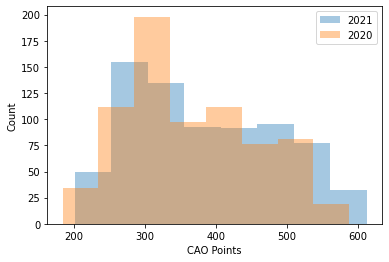

In [22]:
plt.hist(data=data21_20, x = 'Points_21', bins = 8, alpha = 0.4, label = "2021")
plt.hist(data=data21_20, x = 'Points_20', bins =8, alpha = 0.4, label = '2020')
plt.legend()
plt.ylabel("Count")
plt.xlabel("CAO Points")
plt.show()




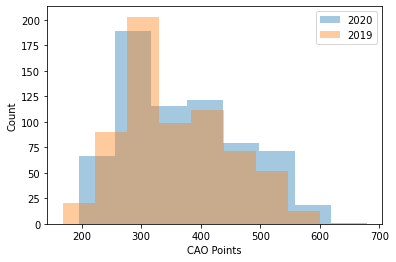

In [23]:
plt.hist(data=data20_19, x = 'EOS_20', bins = 8, alpha = 0.4, label = "2020")
plt.hist(data=data20_19, x = 'EOS_19', bins =8, alpha = 0.4, label = '2019')
plt.legend()
plt.ylabel("Count")
plt.xlabel("CAO Points")
plt.show()

To compare overall points, I have created an overlay histogram for both merged datasets. From this and the summary statistics above, we can see that, overall, points have increased year on year.

As a further comparison, I have decided to look at some individual courses across different colleges. The first course I will compare is Accounting/Accounting & Finance - one of the most popular course choices.

In [24]:
#Filtering both merged datasets for ''Accounting''
data_acc_21_20 = data21_20[data21_20["Title"].str.contains("Accounting")]

data_acc_20_19 = data20_19[data20_19["Title"].str.contains("Accounting")]

data_acc_21_20.describe()

,Points_21,Points_20
count,21.000000,21.000000
mean,366.380952,359.571429
std,98.608558,88.277727
min,242.000000,225.000000
25%,304.000000,305.000000
50%,319.000000,309.000000
75%,424.000000,422.000000
max,553.000000,510.000000


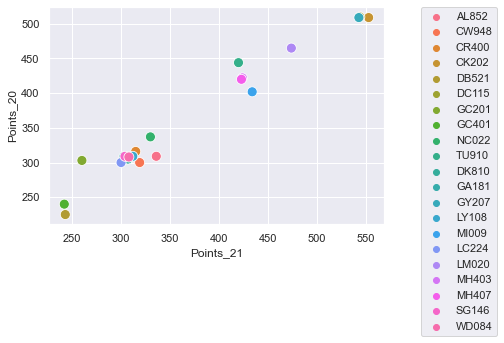

In [25]:
sns.set(style="darkgrid")
sns.scatterplot(data = data_acc_21_20, x = "Points_21", y = "Points_20", hue = "code", s =100)
plt.legend(bbox_to_anchor=(1.11, 1), borderaxespad=0) # used to place 'hue' legend outside the graph

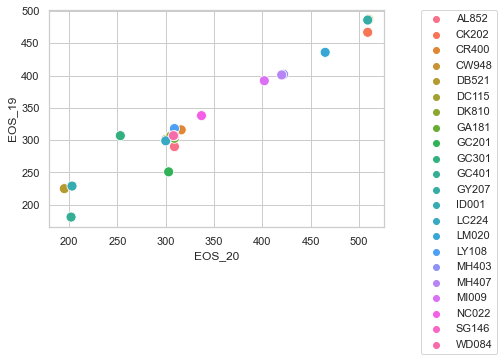

In [26]:
sns.set(style="whitegrid")
sns.scatterplot(data = data_acc_20_19, x = "EOS_20", y = "EOS_19", hue = "code", s =100)
plt.legend(bbox_to_anchor=(1.11, 1), borderaxespad=0) 

In [27]:
data_acc_20_19.describe()

,EOS_20,EOS_19
count,22.000000,22.000000
mean,340.681818,334.045455
std,96.672932,84.251594
min,195.000000,181.000000
25%,300.750000,299.500000
50%,309.000000,307.000000
75%,415.500000,398.750000
max,510.000000,487.000000


From the summary statistics and the scatterplots, we can see that there is a year on year increase for accountancy courses - following the trend of overall point increses from 2019 to 2021. We can also see from the scatterplot, the large points difference between different colleges.

Lastly, I am going to compare points for 'Arts' courses as these are a consistently popular choice for students.

In [28]:
#Filtering both merged datasets for ''Accounting''
data_arts_21_20 = data21_20[data21_20["Title"].str.contains("Arts")]

data_arts_20_19 = data20_19[data20_19["Title"].str.contains("Arts")]

data_arts_21_20.describe()

,Points_21,Points_20
count,32.000000,32.000000
mean,355.500000,337.062500
std,68.002846,61.700075
min,237.000000,212.000000
25%,300.000000,300.000000
50%,353.000000,341.000000
75%,405.500000,379.500000
max,484.000000,451.000000


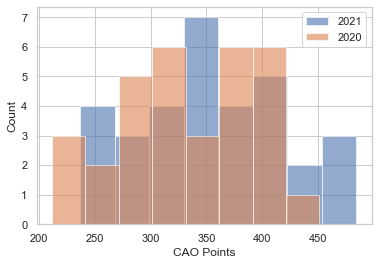

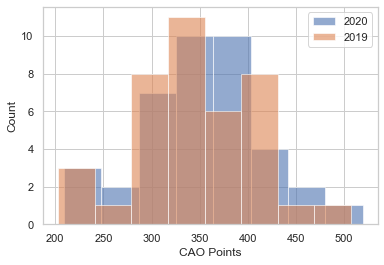

In [29]:
plt.hist(data=data_arts_21_20, x = 'Points_21', bins = 8, alpha = 0.6, label = "2021")
plt.hist(data=data_arts_21_20, x = 'Points_20', bins =8, alpha = 0.6, label = '2020')
plt.legend()
plt.ylabel("Count")
plt.xlabel("CAO Points")
plt.show()


plt.hist(data=data_arts_20_19, x = 'EOS_20', bins = 8, alpha = 0.6, label = "2020")
plt.hist(data=data_arts_20_19, x = 'EOS_19', bins =8, alpha = 0.6, label = '2019')
plt.legend()
plt.ylabel("Count")
plt.xlabel("CAO Points")
plt.show()

In [30]:
data_arts_20_19.describe()

,EOS_20,EOS_19
count,39.000000,39.000000
mean,351.230769,344.692308
std,64.711693,63.468664
min,209.000000,203.000000
25%,310.000000,304.500000
50%,356.000000,342.000000
75%,395.500000,393.500000
max,519.000000,507.000000


From both the histograms and summary statistics, it is clear to see that Arts courses have followed the overall trend of year on year points increases.